# Relation between mutual information and causation

Due to some comments made by Rick, I was triggered in narrowing down the relation between how information theoretical metrics are related to causal relations. In particular how can we deduce from mutual information between a node $s_i$ and the system $S$ that the relation is in fact causal?


An inflated mutual information value could occur when we have a so-called confounder, i.e. where the node could not possible have a causal effect on the system as is found when computing its mutual information.
A study case would be the following graph:


In [1]:
import networkx as nx
from Utils import plotting as plotz
import matplotlib.pyplot as p, numpy as np
p.style.use('seaborn-poster')

# graph = nx.path_graph(5, nx.DiGraph())

graph = nx.path_graph(5, nx.DiGraph()) # directed
# graph.add_edge(0,0)
# graph.add_edges_from([(0,5), (5,6)])
# graph = nx.barabasi_albert_graph(10, 4)
pos = {i: np.array(j) * .08 for i, j in nx.nx_agraph.graphviz_layout(graph, prog = 'neato').items()}
fig, ax = p.subplots()
plotz.addGraphPretty(graph, ax = ax, positions = pos)
ax.axis('off')
fig.show()

/home/casper/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


## Expectations

The directed graph has one common source node (0). However, as 0 has no edges It should share 0 mutual information with the system as it cannot interact with the system directly; its state is set randomly. Alternatively, one could argue that its information would be contained the longest in the system as node 0 information has the most downstream nodes. This view would imply that node 5 can be similar to node 1 and thus be confounded through 0. 

- $I(s_5^{t + t_0} : S^{t_0})$ is confounded
- or $I(s_0^{t + t_0} : S^{t_0})$ is confounded

# Results

## Magnetization matching
I matched the magnetization to the critical temperature:

100%|██████████| 50/50 [00:00<00:00, 548.91it/s]
/home/casper/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


{4: {'neighbors': [3], 'weights': [1.0]}, 3: {'neighbors': [2], 'weights': [1.0]}, 1: {'neighbors': [0], 'weights': [1.0]}, 2: {'neighbors': [1], 'weights': [1.0]}}
Computing mag per t


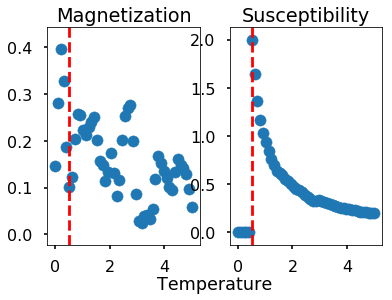

In [2]:
from Toolbox import infcy # montecarlo methods
from Models import fastIsing # models
# match magnetization over temp range
temps        = np.linspace(0, graph.number_of_nodes(), 50)
nSamples     = 100 # int(1e2)

model = fastIsing.Ising(graph)

print(model.adj)
model.magSide    = '' # equal magnetization sampling
model.updateType = 'single' # ultra smooth when single


mag, sus = model.matchMagnetization(temps, nSamples, burninSamples = 0)

from scipy import ndimage
sus = ndimage.gaussian_filter1d(sus, 1)
mag = ndimage.gaussian_filter1d(mag, 1)
sus[np.isfinite(sus) == 0] = 0 # remove nans
idx     = np.argsort(sus)[-1] # get 'max' idx ; second is used
model.t = temps[idx]

# show mag and sus as function of temperature
fig, ax = p.subplots(1, 2)
ax[0].scatter(temps, mag, label = 'Magnetization')
ax[1].scatter(temps, sus, label = 'Susceptebility')
ax[0].axvline(temps[idx], color = 'red', linestyle = 'dashed')
ax[1].axvline(temps[idx], color = 'red', linestyle = 'dashed')

ax[1].set_title('Susceptibility')
ax[0].set_title('Magnetization')
mainax = fig.add_subplot(111, frameon = False, \
                         xticks = [],\
                         yticks = [], \
                        )
mainax.set_xlabel('Temperature', labelpad = 30)
fig.show()

Temperature at the red dashed line was used. The low on average magnetization is expected due to the directed nature of the graph. It is less stable as nodes choose states more randomly and are less stabilized with the detailed balance condition. 

# Mutual information decay

In [12]:
deltas        = 50             #conditional time steps
nSamples      = int(1e5)       # max number of states
step          = int(1e3)   
burninSamples = 100            # burninSamples + step = sim. steps until sample
repeats       = int(1e3)       # number of conditional repeats

reverse = False
reverse = True
if reverse:
    res = np.zeros((nSamples, model.nNodes))
    rngs= np.random.randint(0, model.nNodes, size = nSamples)
    for i in range(nSamples):
        res[i] = model.updateState(rngs[[i]])
    nWindow = deltas
    ps = {}
    px = np.zeros((nWindow, model.nNodes, model.nStates))
    cpx= {}
    Z  = (nSamples - 1 - nWindow) 

    statemapper = {i : idx for idx, i in enumerate([-1, 1])}

    c = 0
    snapshots = {}
    for i in range(nWindow, nSamples - 1):
        tmp   = res[i-nWindow : i]
        state = tuple(np.array(tmp[-1], dtype = int))
        
        snapshots[state] = snapshots.get(state, 0) + 1 / Z
        c += 1
        ps[state] = ps.get(state, 0) + 1
        if state not in cpx:
            cpx[state] = np.zeros(( nWindow, model.nNodes, model.nStates))
        for t, stateAtTime in enumerate(tmp):
            for node, nodeState in enumerate(stateAtTime):
                px[t, node,   statemapper[nodeState]] += 1 / Z
                cpx[state][t, node, statemapper[nodeState]] += 1 
    c = 0
    rmi = np.zeros((nWindow, model.nNodes))
    for state, val in ps.items():
        cpx[state] /= val
        rmi += np.nansum(cpx[state] * np.log2(cpx[state]), axis = -1) * val / Z
    rmi -= np.nansum(px * np.log2(px), axis = -1)
#     mi  = rmi[::-1,:]
    mi  = rmi
else:
    snapshots   = infcy.getSnapShots(model, nSamples, step, burninSamples)
    cpx = infcy.monteCarlo(model, snapshots,\
                          deltas, repeats)
    px, rmi = infcy.mutualInformation(cpx, deltas, snapshots, model)
    from Utils.stats import panzeriTrevesCorrection
    bias = panzeriTrevesCorrection(px, cpx, repeats)
    mi = rmi - bias
print(mi.shape)

(50, 5)


/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log2
/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in multiply


/home/casper/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


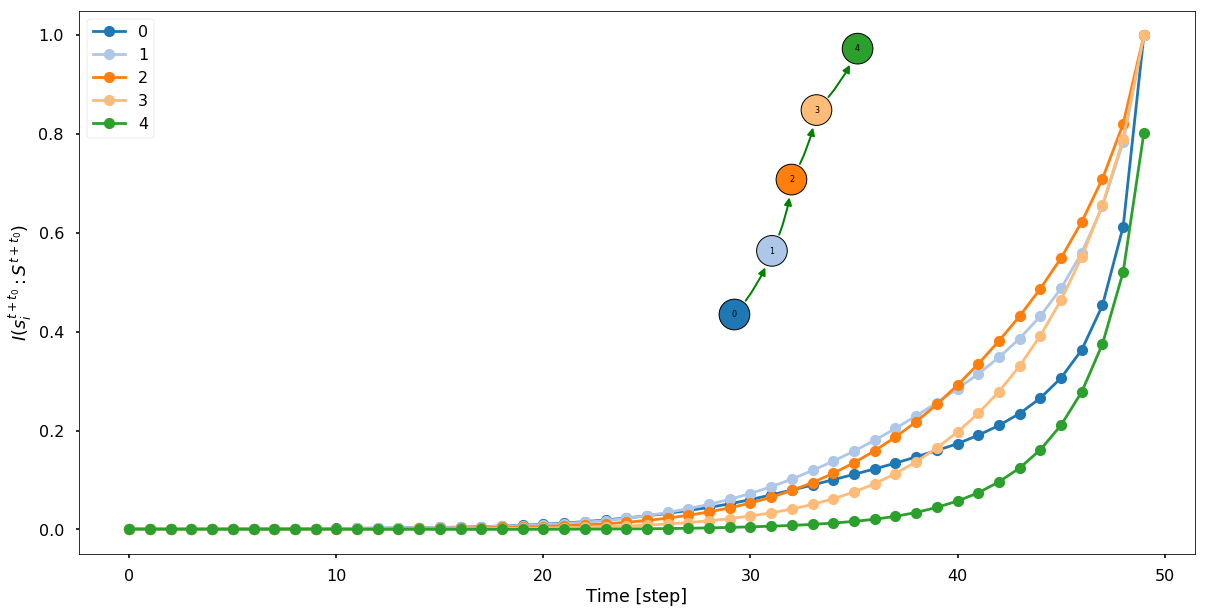

In [13]:
%matplotlib inline
fig, ax = p.subplots(figsize =(20, 10))
elements = []
x = np.arange(mi.shape[0])
colors = p.cm.tab20(np.arange(graph.number_of_nodes()))
from mpl_toolkits.axes_grid.inset_locator import inset_axes

inax = inset_axes(ax,
                    width  ="70%", 
                    height ="60%",
                    loc    = 'upper right')
plotz.addGraphPretty(graph, ax = inax, \
                     cmap = colors, mapping = model.mapping, \
                     positions = pos)

inax.axis('off')
for node, nodeidx in sorted(model.mapping.items(), key = lambda x: x[1]):
    ax.plot(x, mi[:, node], marker ='o', color = colors[nodeidx], label = node)
    element = p.Line2D([0],[0], \
                       color = colors[nodeidx], \
                       label = node, \
                       linestyle = 'none',\
                       marker = 'o')
    
    elements.append(element)
ax.legend()
ax.set(xlabel = 'Time [step]', \
       ylabel = '$I(s_i^{t + t_0} : S^{t + t_0})$',\
       )
fig.show()

Note some values are overlapping:

In [14]:
for node, idx in sorted(model.mapping.items(), key = lambda x : x[0]):
    print(f'Node: {node}, first 4 values decay {mi[:4, idx]}')

Node: 0, first 4 values decay [0.00033034 0.00035267 0.00043815 0.00063429]
Node: 1, first 4 values decay [0.00069777 0.00060328 0.00049772 0.00049556]
Node: 2, first 4 values decay [0.0010142  0.00085207 0.00075448 0.0006995 ]
Node: 3, first 4 values decay [0.00079882 0.0007795  0.00074988 0.0006492 ]
Node: 4, first 4 values decay [0.00099673 0.00095356 0.00089525 0.00082851]


From these results we see the following ranking:


In [15]:
func = lambda x, a, b, c, d, e, f, g: a + b * np.exp(-c * (x - d)) + e * np.exp(-f * (x - g)) 
params = dict(maxfev = int(1e6), \
               bounds = (0, np.inf), \
               p0 = np.ones(func.__code__.co_argcount - 1),\
               jac = 'cs',\
             )

                          
coeffs = plotz.fit(mi.T, func = func, params = params)[0]
import scipy
auc = [scipy.integrate.quad(lambda x: func(x, *c), 0, deltas // 2)[0] for c in coeffs]
for rank, idx in enumerate(np.argsort(auc)[::-1]):
    print(f"Rank {rank + 1} -> node {model.rmapping[idx]}, value : {auc[idx]}")

Rank 1 -> node 2, value : 3.6094039791701205
Rank 2 -> node 1, value : 3.572184893029753
Rank 3 -> node 3, value : 2.905723541810321
Rank 4 -> node 0, value : 2.609777296658779
Rank 5 -> node 4, value : 1.4580676650792999


The results thus imply that 
- the 'leaf' nodes, namely 6 and 4 have similar area under the curve values
- node 0 is not the driver node, but node 1 is

By nudging the nodes, we want to confirm our prediction using information impact

In [16]:
nudge  = 1
pulses = {node : nudge for node in model.mapping}
# pulses = {2 : nudge}
pstar = {}

for (node, pulse) in pulses.items():
    print(f"Nudging {node} with {pulse}")
    model.nudges = {node : pulse}
    print(model.nudges.base)
    conditionalstar, p_, mi_ = infcy.runMC(model, snapshots, deltas, repeats)
    pstar[node] = p_


 66%|██████▌   | 21/32 [00:00<00:00, 192.07it/s]

Nudging 0 with 1
[1. 0. 0. 0. 0.]
Decoding..
starting runs


100%|██████████| 32/32 [00:00<00:00, 176.22it/s]
/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log2
  # Remove the CWD from sys.path while we load stuff.
/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
  0%|          | 0/32 [00:00<?, ?it/s]

Delta =  0.19 sec
Nudging 1 with 1
[0. 1. 0. 0. 0.]
Decoding..
starting runs


100%|██████████| 32/32 [00:00<00:00, 401849.49it/s]


Delta =  0.19 sec
Nudging 2 with 1
[0. 0. 1. 0. 0.]
Decoding..


  0%|          | 0/32 [00:00<?, ?it/s]

starting runs


  0%|          | 0/32 [00:00<?, ?it/s]

Delta =  0.18 sec
Nudging 3 with 1
[0. 0. 0. 1. 0.]
Decoding..
starting runs


  0%|          | 0/32 [00:00<?, ?it/s]

Delta =  0.18 sec
Nudging 4 with 1
[0. 0. 0. 0. 1.]
Decoding..
starting runs


100%|██████████| 32/32 [00:00<00:00, 201.09it/s]

Delta =  0.18 sec


0 3.4795742377576753
1 0.5790327066781427
2 0.44258259682534207
3 0.434711867391516
4 0.0011967515204900998


/home/casper/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


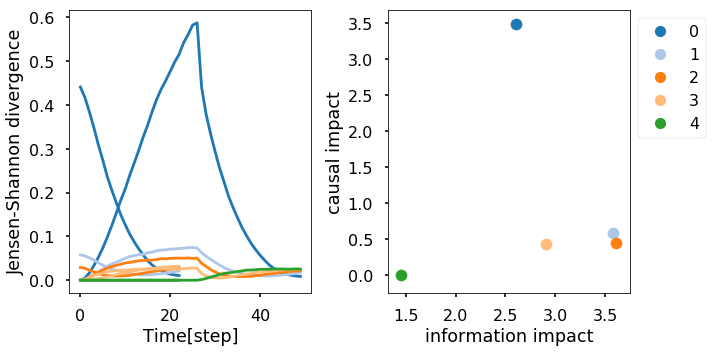

In [18]:
from Utils import stats
fig, ax = p.subplots(1, 2, figsize = (10, 5))

elements = []
for k, v in pstar.items():
    nodeidx = model.mapping[k]
    idx = np.arange(graph.number_of_nodes())
    idx = [i for i in idx if i != nodeidx]
    
    kl = stats.KL(px, v)
#     kl = stats.KL(px, v).mean(-1)
    kl_ = kl[-deltas // 2 + 2:, idx].mean(-1)
    
    coeff = plotz.fit(kl_[None, :], func, params = params)[0]
    causal_auc = scipy.integrate.quad(lambda x: func(x, *coeff.T), 0, deltas // 2)[0]
    print(k, causal_auc)
    ax[0].plot(kl_, color = colors[nodeidx])
    ax[1].scatter(auc[nodeidx], causal_auc, \
                  color = colors[nodeidx])
    
    element = p.Line2D([0],[0], color = colors[nodeidx], \
                      label = k, \
                      linestyle = 'none',\
                      marker = 'o')
    elements.append(element)
    
    ax[0].plot(kl.mean(-1), color = colors[nodeidx])

ax[0].set(xlabel = 'Time[step]',\
         ylabel = 'Jensen-Shannon divergence')
ax[1].set(xlabel = 'information impact', ylabel = 'causal impact')
ax[1].legend(handles = elements, bbox_to_anchor = (1,1), loc = 'upper left')
fig.tight_layout()
fig.show()